In [83]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [84]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [85]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [86]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            print("我加入的判断之前",state)

            if isinstance(state, tuple):
                state = torch.tensor([state[0]], dtype=torch.float).to(self.device)
                print("即将进入神经网络",state)
                action = self.q_net(state).argmax().item()
            else:
                state = torch.tensor([state], dtype=torch.float).to(self.device)
                print("即将进入神经网络",state)
                action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [88]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                print(state)
                action = agent.take_action(state)
                print("输入的动作",action)
                next_state, reward, done, info,_ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 764.86it/s, episode=50,
# return=9.300]
# Iteration 1: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s, episode=100,
# return=12.300]
# Iteration 2: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, episode=150,
# return=123.000]
# Iteration 3: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it, episode=200,
# return=153.600]
# Iteration 4: 100%|██████████| 50/50 [01:30<00:00,  1.80s/it, episode=250,
# return=180.500]
# Iteration 5: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it, episode=300,
# return=185.000]
# Iteration 6: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, episode=350,
# return=193.900]
# Iteration 7: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=400,
# return=196.600]
# Iteration 8: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, episode=450,
# return=193.800]
# Iteration 9: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, episode=500,
# return=200.000]

Iteration 0:  38%|███▊      | 19/50 [00:00<00:00, 106.63it/s, episode=20, return=9.600]

(array([0.03132702, 0.04127556, 0.01066358, 0.02294966], dtype=float32), {})
我加入的判断之前 (array([0.03132702, 0.04127556, 0.01066358, 0.02294966], dtype=float32), {})
即将进入神经网络 tensor([[0.0313, 0.0413, 0.0107, 0.0229]], device='cuda:0')
输入的动作 0
[ 0.03215253 -0.15399769  0.01112257  0.3189779 ]
我加入的判断之前 [ 0.03215253 -0.15399769  0.01112257  0.3189779 ]
即将进入神经网络 tensor([[ 0.0322, -0.1540,  0.0111,  0.3190]], device='cuda:0')
输入的动作 0
[ 0.02907258 -0.34927627  0.01750213  0.6151476 ]
我加入的判断之前 [ 0.02907258 -0.34927627  0.01750213  0.6151476 ]
即将进入神经网络 tensor([[ 0.0291, -0.3493,  0.0175,  0.6151]], device='cuda:0')
输入的动作 0
[ 0.02208706 -0.54463834  0.02980508  0.9132912 ]
我加入的判断之前 [ 0.02208706 -0.54463834  0.02980508  0.9132912 ]
即将进入神经网络 tensor([[ 0.0221, -0.5446,  0.0298,  0.9133]], device='cuda:0')
输入的动作 0
[ 0.01119429 -0.7401505   0.0480709   1.2151906 ]
我加入的判断之前 [ 0.01119429 -0.7401505   0.0480709   1.2151906 ]
即将进入神经网络 tensor([[ 0.0112, -0.7402,  0.0481,  1.2152]], device='cuda:0')
输入的动作 0


Iteration 0:  58%|█████▊    | 29/50 [00:00<00:00, 102.98it/s, episode=30, return=8.600]

Iteration 0:  78%|███████▊  | 39/50 [00:00<00:00, 107.02it/s, episode=40, return=9.400]

tensor([[-0.0644, -1.1504,  0.1167,  1.8782]], device='cuda:0')
输入的动作 0
[-0.08737944 -1.3466308   0.15428935  2.2047265 ]
我加入的判断之前 [-0.08737944 -1.3466308   0.15428935  2.2047265 ]
即将进入神经网络 tensor([[-0.0874, -1.3466,  0.1543,  2.2047]], device='cuda:0')
输入的动作 0
[-0.11431206 -1.5428627   0.19838388  2.540759  ]
我加入的判断之前 [-0.11431206 -1.5428627   0.19838388  2.540759  ]
即将进入神经网络 tensor([[-0.1143, -1.5429,  0.1984,  2.5408]], device='cuda:0')
输入的动作 0
(array([-0.03850674,  0.02290151,  0.04274239,  0.04679262], dtype=float32), {})
我加入的判断之前 (array([-0.03850674,  0.02290151,  0.04274239,  0.04679262], dtype=float32), {})
即将进入神经网络 tensor([[-0.0385,  0.0229,  0.0427,  0.0468]], device='cuda:0')
输入的动作 0
[-0.03804871 -0.17280644  0.04367825  0.35264888]
我加入的判断之前 [-0.03804871 -0.17280644  0.04367825  0.35264888]
即将进入神经网络 tensor([[-0.0380, -0.1728,  0.0437,  0.3526]], device='cuda:0')
输入的动作 0
[-0.04150483 -0.36852142  0.05073122  0.65877867]
我加入的判断之前 [-0.04150483 -0.36852142  0.05073122  0.6587786

Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 105.72it/s, episode=50, return=9.000]


即将进入神经网络 tensor([[-0.0236, -0.4230,  0.0453,  0.6403]], device='cuda:0')
输入的动作 0
[-0.0320482  -0.6187483   0.05815322  0.94688565]
我加入的判断之前 [-0.0320482  -0.6187483   0.05815322  0.94688565]
即将进入神经网络 tensor([[-0.0320, -0.6187,  0.0582,  0.9469]], device='cuda:0')
输入的动作 0
[-0.04442317 -0.81460315  0.07709093  1.2572587 ]
我加入的判断之前 [-0.04442317 -0.81460315  0.07709093  1.2572587 ]
即将进入神经网络 tensor([[-0.0444, -0.8146,  0.0771,  1.2573]], device='cuda:0')
输入的动作 0
[-0.06071523 -1.0106225   0.1022361   1.5730567 ]
我加入的判断之前 [-0.06071523 -1.0106225   0.1022361   1.5730567 ]
即将进入神经网络 tensor([[-0.0607, -1.0106,  0.1022,  1.5731]], device='cuda:0')
输入的动作 0
[-0.08092768 -1.2068045   0.13369724  1.8957983 ]
我加入的判断之前 [-0.08092768 -1.2068045   0.13369724  1.8957983 ]
即将进入神经网络 tensor([[-0.0809, -1.2068,  0.1337,  1.8958]], device='cuda:0')
输入的动作 0
[-0.10506377 -1.4030986   0.1716132   2.2268016 ]
我加入的判断之前 [-0.10506377 -1.4030986   0.1716132   2.2268016 ]
即将进入神经网络 tensor([[-0.1051, -1.4031,  0.1716,  2.22

Iteration 1:   8%|▊         | 4/50 [00:00<00:00, 84.45it/s]

(array([ 0.00776879,  0.01022392,  0.04624231, -0.04277347], dtype=float32), {})
我加入的判断之前 (array([ 0.00776879,  0.01022392,  0.04624231, -0.04277347], dtype=float32), {})
即将进入神经网络 tensor([[ 0.0078,  0.0102,  0.0462, -0.0428]], device='cuda:0')
输入的动作 0
[ 0.00797327 -0.18552957  0.04538684  0.26413327]
我加入的判断之前 [ 0.00797327 -0.18552957  0.04538684  0.26413327]
即将进入神经网络 tensor([[ 0.0080, -0.1855,  0.0454,  0.2641]], device='cuda:0')
输入的动作 0
[ 0.00426268 -0.38126898  0.05066951  0.57077914]
我加入的判断之前 [ 0.00426268 -0.38126898  0.05066951  0.57077914]
即将进入神经网络 tensor([[ 0.0043, -0.3813,  0.0507,  0.5708]], device='cuda:0')
输入的动作 0
[-0.0033627  -0.5770635   0.06208509  0.8789845 ]
我加入的判断之前 [-0.0033627  -0.5770635   0.06208509  0.8789845 ]
即将进入神经网络 tensor([[-0.0034, -0.5771,  0.0621,  0.8790]], device='cuda:0')
输入的动作 0
[-0.01490397 -0.77297163  0.07966478  1.1905218 ]
我加入的判断之前 [-0.01490397 -0.77297163  0.07966478  1.1905218 ]
即将进入神经网络 tensor([[-0.0149, -0.7730,  0.0797,  1.1905]], device='cuda:

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (64,) + inhomogeneous part.

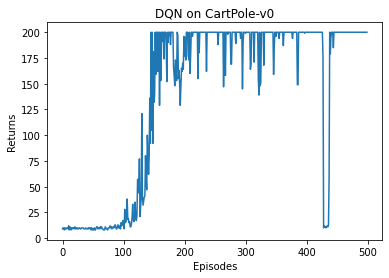

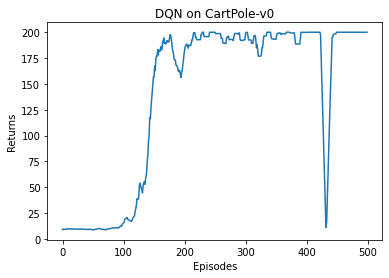

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)